In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.decomposition import PCA
from datetime import timedelta, datetime
import yaml

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Load configuration from YAML file
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

# Configuration
DATA_DIR = config["data_dir"]
WEBSCRAPED_DATA_FILE = DATA_DIR + config["webscraped_data_file"]
TEAM_SCORES_FILE = DATA_DIR + config["team_scores_file"]
PROCESSED_DATA_FILE = config["processed_data_file"]
MODEL_SAVE_PATH = config["model_save_path"]

In [9]:
def calculate_goal_utility(home_goals, away_goals, alpha=0.025, norm=11):
    """
    Calculates the goal utility based on the number of goals scored by home and away teams.

    Parameters:
        home_goals (int): Goals scored by the home team.
        away_goals (int): Goals scored by the away team.
        alpha (float): Scaling factor for the sigmoid function.
        norm (float): Normalization factor.

    Returns:
        float: The calculated goal utility.
    """
    home_goal_utility = ((1.0 / (1.0 + math.exp(-alpha * home_goals))) - 0.5) * norm
    away_goal_utility = ((1.0 / (1.0 + math.exp(-alpha * -away_goals))) - 0.5) * norm
    goal_utility = home_goal_utility + away_goal_utility
    return goal_utility

def calculate_team_score(prev_score, prev_trend, latest_goal_utility, alpha=0.97):
    """
    Updates a team"s score based on previous score, trend, and latest goal utility.

    Parameters:
        prev_score (float): The team"s previous score.
        prev_trend (float): The team"s previous trend.
        latest_goal_utility (float): The latest goal utility.
        alpha (float): Weighting factor.

    Returns:
        float: The updated team score.
    """
    team_score = alpha * (prev_score + prev_trend) + (1.0 - alpha) * latest_goal_utility
    return team_score

def calculate_team_trend(prev_score, prev_trend, latest_score, beta=0.99):
    """
    Updates a team"s trend based on previous score, trend, and latest score.

    Parameters:
        prev_score (float): The team"s previous score.
        prev_trend (float): The team"s previous trend.
        latest_score (float): The team"s latest score.

    Returns:
        float: The updated team trend.
    """
    team_trend = beta * prev_trend + (1 - beta) * (latest_score - prev_score)
    return team_trend

def calculate_home_team_advantage(home_score, away_score):
    """
    Calculates the home team"s advantage based on team scores.

    Parameters:
        home_score (float): The home team"s score.
        away_score (float): The away team"s score.

    Returns:
        float: The home team advantage.
    """
    advantage = 1.0 / (1.0 + math.exp(-0.5 * (home_score - away_score)))
    return advantage

def calculate_home_team_advantage_vectorized(home_scores, away_scores):
    """
    Vectorized calculation of home team advantage.

    Parameters:
        home_scores (pd.Series): Series of home team scores.
        away_scores (pd.Series): Series of away team scores.

    Returns:
        pd.Series: Series of home team advantage values.
    """
    return 1.0 / (1.0 + np.exp(-0.5 * (home_scores - away_scores)))

def calculate_kelly_bet_size(odds, win_prob, resize_factor=30):
    """
    Calculates the optimal bet size using the Kelly criterion.

    Parameters:
        odds (float): Decimal odds offered by the bookmaker.
        win_prob (float): Probability of winning.
        resize_factor (float): Factor to resize the bet size.

    Returns:
        float: The calculated bet size.
    """
    b = odds - 1
    q = 1 - win_prob
    bet_size = ((b * win_prob - q) / b) / resize_factor
    return bet_size


In [81]:
def load_and_preprocess_data(file_path):
    """
    Loads and preprocesses the historical NCAA basketball data.

    Parameters:
        file_path (str): Path to the parquet file containing historical data.

    Returns:
        pd.DataFrame: Preprocessed DataFrame.
    """
    df = pd.read_parquet(file_path).drop_duplicates().sort_values("date").reset_index(drop=True)
    df["home_team"] = df["home_team"] + "_" + df["gender"].str.capitalize()
    df["away_team"] = df["away_team"] + "_" + df["gender"].str.capitalize()
    return df

# Load and preprocess historical data
df = load_and_preprocess_data(WEBSCRAPED_DATA_FILE)

In [77]:
def initialize_team_scores(df):
    """
    Initializes the team scores DataFrame with NaN values.

    Parameters:
        df (pd.DataFrame): The main DataFrame containing match data.

    Returns:
        pd.DataFrame: Initialized team scores DataFrame.
    """
    all_teams = np.sort(df["home_team"].unique())
    date_range = pd.date_range(start=df["date"].min(), end=df["date"].max())
    
    # Create a dictionary with NaN values for each team
    team_scores_dict = {team: [np.nan] * len(date_range) for team in all_teams}
    
    # Add the date range to the dictionary
    team_scores_dict["date"] = date_range
    
    # Create the DataFrame from the dictionary and move date column to the front
    team_scores_df = pd.DataFrame(team_scores_dict)
    team_scores_df = team_scores_df[["date"] + all_teams.tolist()]
    
    return team_scores_df, all_teams

# Initialize team scores DataFrame
team_scores_df, all_teams = initialize_team_scores(df)

In [ ]:
def calculate_team_scores(df, team_scores_df, all_teams):
    """
    Calculates team scores over time with progress bars.
    
    Parameters:
        df (pd.DataFrame): The main DataFrame containing match data.
        team_scores_df (pd.DataFrame): DataFrame to store team scores.
        all_teams (list): List of all team names.
    
    Returns:
        pd.DataFrame: Updated team_scores_df with calculated scores.
    """
    # Initialize previous scores and trends
    prev_scores = {team: 0 for team in all_teams}
    prev_trends = {team: 0 for team in all_teams}
    
    # Calculate total iterations for the progress bar
    total_dates = len(team_scores_df["date"])
    total_teams = len(all_teams)
    total_iterations = total_dates * total_teams
    
    # Initialize tqdm progress bar
    with tqdm(total=total_iterations, desc="Calculating Team Scores", unit="iteration") as pbar:
        # Iterate over dates
        for date in team_scores_df["date"]:
            matches_on_date = df[df["date"] == date]
            # Iterate over teams
            for team in all_teams:
                team_matches = matches_on_date[
                    (matches_on_date["home_team"] == team) | 
                    (matches_on_date["away_team"] == team)
                ]
                if not team_matches.empty:
                    match = team_matches.iloc[0]
                    home_goals = match["home_team_score"]
                    away_goals = match["away_team_score"]
                    
                    if match["home_team"] == team:
                        team_goal_utility = calculate_goal_utility(home_goals, away_goals)
                    else:
                        team_goal_utility = -calculate_goal_utility(home_goals, away_goals)
                    
                    latest_score = calculate_team_score(prev_scores[team], prev_trends[team], team_goal_utility)
                    latest_trend = calculate_team_trend(prev_scores[team], prev_trends[team], latest_score)
                    
                    prev_scores[team] = latest_score
                    prev_trends[team] = latest_trend
                
                # Update the team score for the date
                team_scores_df.loc[team_scores_df["date"] == date, team] = prev_scores[team]
                
                # Update the progress bar
                pbar.update(1)
    
    return team_scores_df

# Calculate team scores with progress bar
team_scores_df = calculate_team_scores(df, team_scores_df, all_teams)

team_scores_df.to_parquet(TEAM_SCORES_FILE)

Calculating Team Scores:   1%|          | 189966/30559076 [14:29<38:36:10, 218.53iteration/s]


KeyboardInterrupt: 

In [82]:
def calculate_home_team_advantage_vectorized(home_scores, away_scores):
    """
    Vectorized calculation of home team advantage.

    Parameters:
        home_scores (pd.Series): Series of home team scores.
        away_scores (pd.Series): Series of away team scores.

    Returns:
        pd.Series: Series of home team advantage values.
    """
    return 1.0 / (1.0 + np.exp(-0.5 * (home_scores - away_scores)))

def assign_team_scores(df, team_scores_df):
    """
    Assigns team scores and calculates home team advantage.

    Parameters:
        df (pd.DataFrame): The main DataFrame containing match data.
        team_scores_df (pd.DataFrame): DataFrame containing team scores.

    Returns:
        pd.DataFrame: Updated DataFrame with team scores and home team advantage.
    """
    # Ensure date columns are of datetime type
    df["date"] = pd.to_datetime(df["date"])
    team_scores_df["date"] = pd.to_datetime(team_scores_df["date"])

    # Ensure team columns are of string type
    df["home_team"] = df["home_team"].astype(str)
    df["away_team"] = df["away_team"].astype(str)
    team_scores_df.columns = team_scores_df.columns.astype(str)

    # Melt the team_scores_df to long format
    team_scores_df_long = team_scores_df.melt(id_vars="date", var_name="team", value_name="team_score")

    # Merge team scores with the main DataFrame
    df = df.merge(team_scores_df_long.rename(columns={"team": "home_team", "team_score": "home_team_score_z"}), on=["date", "home_team"], how="left")
    df = df.merge(team_scores_df_long.rename(columns={"team": "away_team", "team_score": "away_team_score_z"}), on=["date", "away_team"], how="left")

    # Calculate home team advantage
    df["home_team_advantage"] = calculate_home_team_advantage_vectorized(df["home_team_score_z"], df["away_team_score_z"])
    return df

# Assign team scores and calculate home team advantage
df = assign_team_scores(df, team_scores_df)

## Generate New Features

In [ ]:
def feature_engineering(df):
    """
    Performs feature engineering to create additional features for the machine learning model.

    Parameters:
        df (pd.DataFrame): The main DataFrame containing match data with team scores.

    Returns:
        pd.DataFrame: DataFrame with new features.
    """
    logging.info("Starting feature engineering.")
    
    # Ensure the date column is of datetime type
    df["date"] = pd.to_datetime(df["date"])
    
    # Sort the DataFrame by date
    df = df.sort_values("date").reset_index(drop=True)
    
    # Create a copy for feature engineering
    feature_df = df.copy()
    
    # Initialize new feature columns
    feature_df["home_win_last_5"] = 0
    feature_df["away_win_last_5"] = 0
    feature_df["home_avg_points_last_5"] = 0.0
    feature_df["away_avg_points_last_5"] = 0.0
    feature_df["home_avg_concede_last_5"] = 0.0
    feature_df["away_avg_concede_last_5"] = 0.0
    feature_df["home_recent_diff"] = 0.0
    feature_df["away_recent_diff"] = 0.0
    feature_df["home_total_diff"] = 0.0
    feature_df["away_total_diff"] = 0.0
    feature_df["home_win_head_to_head"] = 0
    feature_df["away_win_head_to_head"] = 0
    feature_df["home_strength"] = 0.0
    feature_df["away_strength"] = 0.0
    
    # Define the number of recent games to consider
    RECENT_GAMES = 5
    
    # Create a dictionary to store team history
    team_history = {team: [] for team in pd.concat([df["home_team"], df["away_team"]]).unique()}
    
    # Initialize progress bar
    total_matches = len(feature_df)
    with tqdm(total=total_matches, desc="Feature Engineering", unit="match") as pbar:
        for index, row in feature_df.iterrows():
            date = row["date"]
            home_team = row["home_team"]
            away_team = row["away_team"]
            home_score = row["home_team_score"]
            away_score = row["away_team_score"]
            match_result = 1 if home_score > away_score else 0
            
            # Update head-to-head statistics
            if (home_team, away_team) not in team_history:
                team_history[(home_team, away_team)] = []
            if (away_team, home_team) not in team_history:
                team_history[(away_team, home_team)] = []
            
            # Head-to-head wins
            head_to_head = team_history.get((home_team, away_team), [])
            head_to_head_wins = sum(head_to_head)
            feature_df.at[index, "home_win_head_to_head"] = head_to_head_wins
            
            head_to_head_away = team_history.get((away_team, home_team), [])
            head_to_head_away_wins = sum(head_to_head_away)
            feature_df.at[index, "away_win_head_to_head"] = head_to_head_away_wins
            
            # Recent performance (last 5 games)
            # Home team
            home_recent = team_history[home_team][-RECENT_GAMES:]
            if RECENT_GAMES <= len(home_recent):
                home_win_last = sum(game["win"] for game in home_recent[-RECENT_GAMES:])
            else:
                home_win_last = sum(game["win"] for game in home_recent)
            feature_df.at[index, "home_win_last_5"] = home_win_last
            home_avg_points = np.mean([game["points_scored"] for game in home_recent[-RECENT_GAMES:]]) if home_recent else 0.0
            feature_df.at[index, "home_avg_points_last_5"] = home_avg_points
            home_avg_concede = np.mean([game["points_conceded"] for game in home_recent[-RECENT_GAMES:]]) if home_recent else 0.0
            feature_df.at[index, "home_avg_concede_last_5"] = home_avg_concede
            home_recent_diff = home_avg_points - home_avg_concede
            feature_df.at[index, "home_recent_diff"] = home_recent_diff
            
            # Away team
            away_recent = team_history[away_team][-RECENT_GAMES:]
            if RECENT_GAMES <= len(away_recent):
                away_win_last = sum(game["win"] for game in away_recent[-RECENT_GAMES:])
            else:
                away_win_last = sum(game["win"] for game in away_recent)
            feature_df.at[index, "away_win_last_5"] = away_win_last
            away_avg_points = np.mean([game["points_scored"] for game in away_recent[-RECENT_GAMES:]]) if away_recent else 0.0
            feature_df.at[index, "away_avg_points_last_5"] = away_avg_points
            away_avg_concede = np.mean([game["points_conceded"] for game in away_recent[-RECENT_GAMES:]]) if away_recent else 0.0
            feature_df.at[index, "away_avg_concede_last_5"] = away_avg_concede
            away_recent_diff = away_avg_points - away_avg_concede
            feature_df.at[index, "away_recent_diff"] = away_recent_diff
            
            # Total performance
            # Prevent division by zero
            home_concede_mean = feature_df.loc[:index, "home_avg_concede_last_5"].mean() if feature_df.loc[:index, "home_avg_concede_last_5"].count() > 0 else 0.0
            home_total_diff = feature_df.loc[:index, "home_team_score"].sum() - feature_df.loc[:index, "home_team_score"].count() * home_concede_mean
            feature_df.at[index, "home_total_diff"] = home_total_diff
            
            away_concede_mean = feature_df.loc[:index, "away_avg_concede_last_5"].mean() if feature_df.loc[:index, "away_avg_concede_last_5"].count() > 0 else 0.0
            away_total_diff = feature_df.loc[:index, "away_team_score"].sum() - feature_df.loc[:index, "away_team_score"].count() * away_concede_mean
            feature_df.at[index, "away_total_diff"] = away_total_diff
            
            # Opponent strength adjustment
            # Using head-to-head wins as a proxy for opponent strength
            feature_df.at[index, "home_strength"] = head_to_head_wins
            feature_df.at[index, "away_strength"] = head_to_head_away_wins
            
            # Update team history
            team_history[home_team].append({"points_scored": home_score, "points_conceded": away_score, "win": match_result})
            team_history[away_team].append({"points_scored": away_score, "points_conceded": home_score, "win": 1 - match_result})
            
            # Update head-to-head history
            team_history[(home_team, away_team)].append(match_result)
            team_history[(away_team, home_team)].append(1 - match_result)
            
            # Update progress bar
            pbar.update(1)
    
    logging.info("Feature engineering completed.")
    return feature_df

# Perform feature engineering
df = feature_engineering(df)
df.to_parquet(PROCESSED_DATA_FILE)

2024-11-11 12:30:19,747 - INFO - Starting feature engineering.
Feature Engineering:   0%|          | 958/300968 [00:03<18:56, 263.89match/s] 


KeyboardInterrupt: 

In [87]:
df

,date,home_team,home_team_ranking,home_team_score,away_team,away_team_ranking,away_team_score,gender,home_team_score_z,away_team_score_z,...,home_total_diff,away_total_diff,home_win_head_to_head,away_win_head_to_head,home_away_advantage,away_away_advantage,home_trend,away_trend,home_strength,away_strength
0,1986-01-02,Holy Cross_M,NaN,77,Yale_M,NaN,86,m,NaN,NaN,...,77.0,8.600000e+01,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,1986-01-02,Hartford_M,NaN,54,Virginia_M,NaN,73,m,NaN,NaN,...,131.0,1.590000e+02,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,1986-01-02,Cornell_M,NaN,78,Utica_M,NaN,88,m,NaN,NaN,...,209.0,2.470000e+02,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,1986-01-02,Oregon_M,NaN,65,UCLA_M,NaN,71,m,NaN,NaN,...,274.0,3.180000e+02,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,1986-01-02,Rice_M,NaN,64,TCU_M,NaN,66,m,NaN,NaN,...,338.0,3.840000e+02,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300963,2023-04-01,Columbia_F,NaN,59,Kansas_F,NaN,66,f,0.515185,0.323001,...,-926381.0,1.110473e+06,0,0,0.0,0.0,0.0,0.0,0.0,0.0
300964,2023-04-01,Florida Atlantic_M,9.0,71,San Diego State_M,5.0,72,m,0.417491,0.320446,...,-926374.4,1.110488e+06,0,2,0.0,0.0,0.0,0.0,0.0,2.0
300965,2023-04-01,Miami_M,NaN,59,UConn_M,NaN,72,m,0.181644,0.432212,...,-926388.6,1.110499e+06,8,16,0.0,0.0,0.0,0.0,8.0,16.0
300966,2023-04-02,LSU_F,NaN,102,Iowa_F,NaN,85,f,0.648083,0.476098,...,-926340.4,1.110515e+06,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Random Forest Model

In [93]:
def prepare_ml_data(df):
    """
    Prepares data for machine learning model training.

    Parameters:
        df (pd.DataFrame): The main DataFrame containing match data.

    Returns:
        pd.DataFrame, pd.Series: Features DataFrame and target Series.
    """
    # Create target variable
    df["match_result"] = (df["home_team_score"] > df["away_team_score"]).astype(int)

    # Encode categorical variables
    df["gender"] = df["gender"].map({"m": 1, "f": 0})

    # Select features
    features = ["gender", "home_team_score_z", "away_team_score_z", "home_team_advantage", "home_win_last_5", "away_win_last_5",
       "home_avg_points_last_5", "away_avg_points_last_5",
       "home_avg_concede_last_5", "away_avg_concede_last_5",
       "home_recent_diff", "away_recent_diff"]
    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    y = df["match_result"]
    return X_scaled, y, features

# Prepare data for ML
X, y, features = prepare_ml_data(df.dropna(subset=["home_team_score_z", "away_team_score_z"]))

/var/folders/cl/f6kbkf0n2yxcjtgnl1kfbqxc0000gn/T/ipykernel_58713/2141545641.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["match_result"] = (df["home_team_score"] > df["away_team_score"]).astype(int)
/var/folders/cl/f6kbkf0n2yxcjtgnl1kfbqxc0000gn/T/ipykernel_58713/2141545641.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["gender"] = df["gender"].map({"m": 1, "f": 0})


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def train_ml_model(X, y):
    """
    Trains a LightGBM machine learning model.

    Parameters:
        X (pd.DataFrame): Features DataFrame.
        y (pd.Series): Target variable.

    Returns:
        lgb.Booster: Trained LightGBM model.
    """
    # Split data into training and test sets
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=42)

    # Create LightGBM datasets
    train_data = lgb.Dataset(train_X, label=train_y)
    test_data = lgb.Dataset(test_X, label=test_y)

    # Define parameters
    params = {
        "boosting_type": "gbdt",
        "objective": "binary",
        "learning_rate": 0.01,
        "regularization": 0.01,
        "num_leaves": 25,
        "metric": "binary_logloss",
        "verbose": -1
    }

    # Train the model
    model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=1000)

    # Evaluate the model
    y_pred = model.predict(test_X, num_iteration=model.best_iteration)
    y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
    accuracy = accuracy_score(test_y, y_pred_binary)
    print(f"Model accuracy: {accuracy * 100:.2f}%")

    return model

# Train the machine learning model
model = train_ml_model(X, y)


Model accuracy: 72.85%


## Neural Network

In [ ]:
def prepare_nn_data(X, y):
    """
    Splits and scales the data for Neural Network training.
    """
    # Split data
    train_X, test_X, train_y, test_y = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    test_X = scaler.transform(test_X)
    
    return train_X, test_X, train_y, test_y

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

def train_nn(train_X, train_y, test_X, test_y):
    """
    Builds and trains a Neural Network with adjusted learning rate and regularization.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8, activation="relu",
                              input_shape=(train_X.shape[1],),
                              kernel_regularizer=regularizers.l2(0.001)),
        tf.keras.layers.Dense(8, activation="relu",
                              kernel_regularizer=regularizers.l2(0.001)),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    
    # Adjust learning rate
    learning_rate = 0.01  # Set your desired learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    
    history = model.fit(
        train_X, train_y,
        epochs=30,
        batch_size=32,
        validation_data=(test_X, test_y),
        verbose=1
    )
    
    # Evaluate
    loss, accuracy = model.evaluate(test_X, test_y, verbose=0)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    
    return model


def main():
    logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
    logging.info("Neural Network Training Started.")    
    
    # Prepare data
    train_X, test_X, train_y, test_y = prepare_nn_data(X, y)
    
    # Train simple NN
    model_simple = train_nn(train_X, train_y, test_X, test_y)
    
    
    # Save models
    model_simple.save("simple_nn_model.h5")
    logging.info("Neural Network Model Saved.")
    
    logging.info("Neural Network Training Completed.")
    
if __name__ == "__main__":
    main()

# Test Accuracy: 72.70% for 8-8 network, 0.01 learning rate, 0.001 regularization, 32 batch size, 30 epochs
# Test Accuracy: 72.37% for 16-8 network, 0.01 learning rate, 0.001 regularization, 32 batch size, 30 epochs

2024-10-30 15:15:38,715 - INFO - Neural Network Training Started.


Epoch 1/30
7466/7466 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.7221 - loss: 0.5481 - val_accuracy: 0.7142 - val_loss: 0.5527
Epoch 2/30
7466/7466 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.7242 - loss: 0.5403 - val_accuracy: 0.7258 - val_loss: 0.5413
Epoch 3/30
7466/7466 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.7230 - loss: 0.5402 - val_accuracy: 0.7259 - val_loss: 0.5407
Epoch 4/30
7466/7466 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7252 - loss: 0.5391 - val_accuracy: 0.7258 - val_loss: 0.5403
Epoch 5/30
7466/7466 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7239 - loss: 0.5395 - val_accuracy: 0.7210 - val_loss: 0.5438
Epoch 6/30
7466/7466 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.7245 - loss: 0.5394 - val_accuracy: 0.7242 - val_loss: 0.5412
Epoch 7/30
7466/7466 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.7232 - loss: 0.5409 - val_accuracy: 0.7260 - val_loss: 0.5392
Epoch 8/30
7466/7466 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.7237 - loss: 0.5

2024-10-30 15:22:21,080 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2024-10-30 15:22:21,150 - INFO - Neural Network Model Saved.
2024-10-30 15:22:21,152 - INFO - Neural Network Training Completed.


Test Accuracy: 71.81%


## PCA

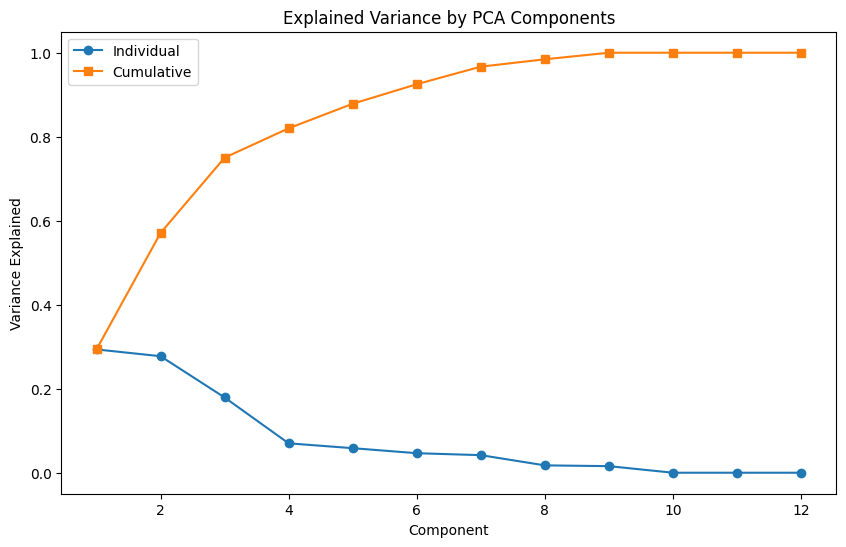

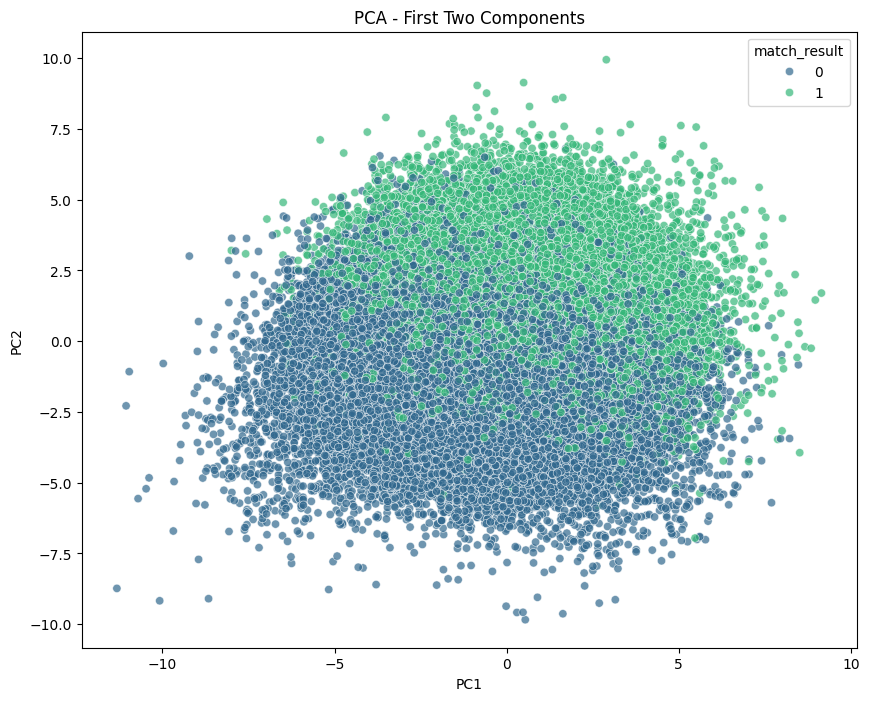

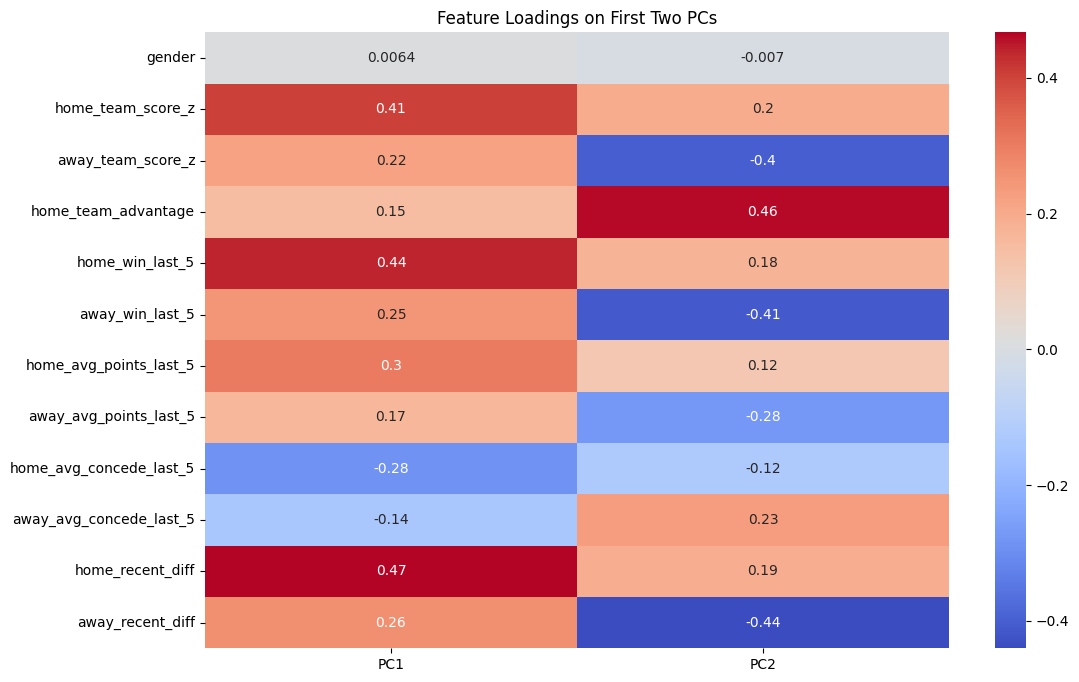

Number of components to explain 90% variance: 6


In [95]:
def evaluate_features_with_pca(X, y):
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Convert X_scaled to DataFrame to retain column names
    X_scaled_df = pd.DataFrame(X_scaled, columns=features)
    
    # PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled_df)
    
    # Explained Variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    # Plot Explained Variance
    plt.figure(figsize=(10,6))
    plt.plot(range(1, len(explained_variance)+1), explained_variance, marker="o", label="Individual")
    plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker="s", label="Cumulative")
    plt.title("Explained Variance by PCA Components")
    plt.xlabel("Component")
    plt.ylabel("Variance Explained")
    plt.legend()
    plt.show()
    
    # First two PCs
    pca_df = pd.DataFrame(data=X_pca[:, :2], columns=["PC1", "PC2"])
    pca_df = pd.concat([pca_df, y.reset_index(drop=True)], axis=1)
    
    plt.figure(figsize=(10,8))
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="match_result", palette="viridis", alpha=0.7)
    plt.title("PCA - First Two Components")
    plt.show()
    
    # Loadings
    loadings = pd.DataFrame(pca.components_.T, columns=[f"PC{i}" for i in range(1, len(explained_variance)+1)], index=features)
    plt.figure(figsize=(12,8))
    sns.heatmap(loadings.iloc[:, :2], annot=True, cmap="coolwarm")
    plt.title("Feature Loadings on First Two PCs")
    plt.show()
    
    # Determine number of components for 90% variance
    pca_90 = PCA(n_components=0.90)
    X_pca_90 = pca_90.fit_transform(X_scaled_df)
    print(f"Number of components to explain 90% variance: {pca_90.n_components_}")
    
    return pca_90, X_pca_90

# Usage
pca_model, X_pca_90 = evaluate_features_with_pca(X, y)
